# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Alexandre Flachs - __[alexandre.flachs@ulb.be](mailto:alexandre.flachs@ulb.be) - Student ID 474748__
### Marie Giot - __[marie.giot@ulb.be](mailto:marie.giot@ulb.be) - Student ID 474915__
### Jeanne Szpirer - __[jeanne.szpirer@ulb.be](mailto:jeanne.szpirer@ulb.be) - Student ID 477286__

### Video presentation: www.youtube.com/abcd1234

## Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines


# Introduction


The project's goal is to propose efficient machine learning methods to predict the likelihood of patients to get a vaccine for H1N1 or Seasonal Flu. This challenge was inititated by the "Driven Data" plateforme. Four different techniques are presented hereunder and their costs and their results will be discussed. The group also submitted its result on the Driven Data plateforme for the challenge in order to receive a score and compare it to the other paticipants.

# Data preprocessing

Before working any model we need to preprocess the data to make it usefull. This pipeline in divided intro three parts :
1. **Missing value imputation** : Replace missing values, possibly using other known values
2. **Feature engineering** : Define useful features from available ones. 
3. **Feature selection** : Some features might be useless or give wrong indications to the model, we might need to remove some features.

Let's start by importing our data, then develop each of the above parts.

In [2]:
# Training set features
training_set_features <- read.csv("training_set_features.csv", stringsAsFactors = T, na.strings = c("NA", ""))
dim(training_set_features)

# Test set features
test_set_features <- read.csv("test_set_features.csv", stringsAsFactors = T, na.strings = c("NA", ""))
dim(test_set_features)

# Training set labels
training_set_labels <- read.csv("training_set_labels.csv", stringsAsFactors = T, na.strings = c("NA", ""))
dim(training_set_labels)

[1] 26707    36

[1] 26708    36

[1] 26707     3

We can see that the training features set and the training labels set has the same amount of lines, this is a first good sign because it means that we have an "answer" for every training line.

## Missing value imputation


We summarize our data before doing any work.

In [3]:
summary(training_set_features)

 respondent_id    h1n1_concern   h1n1_knowledge  behavioral_antiviral_meds
 Min.   :    0   Min.   :0.000   Min.   :0.000   Min.   :0.00000          
 1st Qu.: 6676   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.00000          
 Median :13353   Median :2.000   Median :1.000   Median :0.00000          
 Mean   :13353   Mean   :1.618   Mean   :1.263   Mean   :0.04884          
 3rd Qu.:20030   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:0.00000          
 Max.   :26706   Max.   :3.000   Max.   :2.000   Max.   :1.00000          
                 NA's   :92      NA's   :116     NA's   :71               
 behavioral_avoidance behavioral_face_mask behavioral_wash_hands
 Min.   :0.0000       Min.   :0.00000      Min.   :0.0000       
 1st Qu.:0.0000       1st Qu.:0.00000      1st Qu.:1.0000       
 Median :1.0000       Median :0.00000      Median :1.0000       
 Mean   :0.7256       Mean   :0.06898      Mean   :0.8256       
 3rd Qu.:1.0000       3rd Qu.:0.00000      3rd Qu.:1.0000       
 Max.   :1

We see that we have many missing values, in most features. We can compare the number of lines left if we remove any line containing any missing value.

In [4]:
# First method
cat("Training set : ", dim(training_set_features)[1], "->", dim(na.omit(training_set_features))[1], "\n")
cat("Test set     : ", dim(test_set_features)[1], "->", dim(na.omit(test_set_features))[1], "\n")
cat("Training labs: ", dim(training_set_labels)[1], "->", dim(na.omit(training_set_labels))[1])


Training set :  26707 -> 6437 
Test set     :  26708 -> 6499 
Training labs:  26707 -> 26707

At least no line from the training labels misses any value, we can thus use every entry from the training set for both targets.
Counting the number of missing value per feature allows us to see if some of the could be useless. The health insurance, employment occupation and employment industry lines are the emptiest (almost half of the lines miss this data) but by intuition this might be a huge factor in the vaccination decision so we keep it for now.

In [5]:
# On peut aussi regarder si certaines colonnes n'ont vraiment quasi aucune valeur, dans ce cas, ça vaut pas vraiment la peine de garder
a <- sapply(training_set_features, function(x) sum(is.na(x)))
print(a[order(a, decreasing=T)])

      employment_occupation         employment_industry 
                      13470                       13330 
           health_insurance              income_poverty 
                      12274                        4423 
           doctor_recc_h1n1        doctor_recc_seasonal 
                       2160                        2160 
                rent_or_own           employment_status 
                       2042                        1463 
             marital_status                   education 
                       1408                        1407 
      chronic_med_condition        child_under_6_months 
                        971                         820 
              health_worker opinion_seas_sick_from_vacc 
                        804                         537 
          opinion_seas_risk opinion_seas_vacc_effective 
                        514                         462 
opinion_h1n1_sick_from_vacc opinion_h1n1_vacc_effective 
                        395    

What happens if we remove these fields ?

In [6]:
useful_nas <- which(sapply(test_set_features, function(x) sum(is.na(x))) > 10000)

cat("Training set : ",
    dim(training_set_features[,-useful_nas])[1], "->",
    dim(na.omit(training_set_features[,-useful_nas]))[1], "\n")
cat("Test set     : ", dim(test_set_features[,-useful_nas])[1], "->",
    dim(na.omit(test_set_features[,-useful_nas]))[1], "\n")
cat("Training labels: ", dim(training_set_labels)[1], "->", dim(na.omit(training_set_labels))[1])


Training set :  26707 -> 19642 
Test set     :  26708 -> 19592 
Training labels:  26707 -> 26707

There are much less lines containing missing values. We will thus manage the three most missed fields differently.

## Imputation of missing numerical values

In [7]:
# Imputation will be the same for training and testing so we merge them
features_set <- rbind(training_set_features, test_set_features)


# Note the indexes of each dataset to get them back after
tr_indexes <- 1:nrow(training_set_features)
ts_indexes <- (nrow(training_set_features)+1):(nrow(training_set_features) + nrow(test_set_features))


### Integer encoding of some variables

In [8]:
levels(features_set[, "age_group"])
levels(features_set[, "age_group"]) <- 0:4
features_set[, "age_group"] <- as.numeric(features_set[, "age_group"])
features_set[, "age_group"] <- (features_set[, "age_group"] - 1)/4

levels(features_set[, "education"])
levels(features_set[, "education"]) <- 0:3
features_set[, "education"] <- as.numeric(features_set[, "education"])
features_set[, "education"] <- (features_set[, "education"] - 1)/3

levels(features_set[, "income_poverty"])
levels(features_set[, "income_poverty"]) <- c(1, 2, 0)
features_set[, "income_poverty"] <- as.numeric(features_set[, "income_poverty"])
features_set[, "income_poverty"] <- (features_set[, "income_poverty"] - 1)/2

levels(features_set[, "census_msa"])
levels(features_set[, "census_msa"]) <- c(1, 2, 0)
features_set[, "census_msa"] <- as.numeric(features_set[, "census_msa"])
features_set[, "census_msa"] <- (features_set[, "census_msa"] - 1)/2


[1] "18 - 34 Years" "35 - 44 Years" "45 - 54 Years" "55 - 64 Years"
[5] "65+ Years"

[1] "< 12 Years"       "12 Years"         "College Graduate" "Some College"

[1] "<= $75,000, Above Poverty" "> $75,000"                
[3] "Below Poverty"

[1] "MSA, Not Principle  City" "MSA, Principle City"     
[3] "Non-MSA"

### Non negative matrix factorization based imputation

Non negative matrix factorization is a procedure which consists of approximating a matrix with non negative values as the product of two matrices having smaller dimensions. More formally, a matrix $M$ of dimension $m\times n$ is decomposed into two matrices $W$ and $H$ of dimensions $m\times p$ and $p\times n$ respectively such that $M \approx WH$.

More details concerning the imputation method can be found here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8510447/

PseudoCode :

```pseudocode
Consider M of dim m x n having missing values
Fix N > 0
Normalize M and replace NAs using mean imputation
k1 <- floor(max(abs(rank(M) - N/2), 1))
kN = min(abs(rX + N/2), m, n)

# Compute approximation
initialize X array of size kN-k1+1
for k in 1...kN-k1+1 do
    Compute the nNMF of M on non missing values and store the result in X[k]

## Based on all X[k], reconstruct M
# Weights based only on non missing values of M
initialize d array of size kN-k1+1
for k in 1...kN-k1+1 do
    Compute d[k] = sum(X_ij - M_ij)/ nb_nonNA

# Reconstruct
Initialize divisor=0, M_hat of 0 with same dim as M
for k in 1...kN-k1+1 do
    M_hat += exp(-d[k])*X[k]
    denum += exp(-d[k])
M_hat <- M_hat/denum
```


After these steps, M_hat does not contain missing values and the imputation is based on local and global information.

In [9]:
library(NMFN)

# We work only on the columns of numeric type
numeric_variables_idx<-which(sapply(features_set[1,],class)!="factor")
numeric_variables_idx <- numeric_variables_idx[-c(1, 16)] # Remove resp ID and health insur

# We need to normalize this data to use efficient nNMF
library("caret")

ss <- preProcess(as.data.frame(features_set[, numeric_variables_idx]), method=c("range"))
features_set[,numeric_variables_idx] <- predict(ss, as.data.frame(features_set[, numeric_variables_idx]))
summary(features_set[, numeric_variables_idx])


Loading required package: ggplot2

Loading required package: lattice



  h1n1_concern    h1n1_knowledge   behavioral_antiviral_meds
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000          
 1st Qu.:0.3333   1st Qu.:0.5000   1st Qu.:0.00000          
 Median :0.6667   Median :0.5000   Median :0.00000          
 Mean   :0.5403   Mean   :0.6321   Mean   :0.04924          
 3rd Qu.:0.6667   3rd Qu.:1.0000   3rd Qu.:0.00000          
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000          
 NA's   :177      NA's   :238      NA's   :150              
 behavioral_avoidance behavioral_face_mask behavioral_wash_hands
 Min.   :0.0000       Min.   :0.00000      Min.   :0.0000       
 1st Qu.:0.0000       1st Qu.:0.00000      1st Qu.:1.0000       
 Median :1.0000       Median :0.00000      Median :1.0000       
 Mean   :0.7277       Mean   :0.06913      Mean   :0.8258       
 3rd Qu.:1.0000       3rd Qu.:0.00000      3rd Qu.:1.0000       
 Max.   :1.0000       Max.   :1.00000      Max.   :1.0000       
 NA's   :421          NA's   :38           NA's   :82    

In [10]:
# Define the function that will compute nmf
nfm_mult_upd <- function(R, K, missing_idx, maxit=800, eps=2.2204e-16) {
    # Using weighted multiplicative rule Zhu 2016
    # init random W and H
    print(paste("[INFO] : NMF with k=", K))
    R <- as.matrix(R)
    I <- dim(R)[1]
    J <- dim(R)[2]
    M <- matrix(1, nrow = dim(R)[1], ncol = dim(R)[2])
    M[missing_idx] <- 0
    X <- R # Store original R
    R <- R*M
    W <- matrix(runif(I*K), nrow = I, ncol = K)
    H <- matrix(runif(K*J), nrow = K, ncol = J)
    
    n <- 0
    d1 <- 1000
    d2 <- 1000
    while(n < maxit && !(d1 < eps && d2 < eps)) {
        if (n %% 100 == 0) {
            print(paste("[INFO] : iter", n, " Relative error is :", distance2(X, W%*%H)/distance2(X, R*0)))
        }
        newH <- H* (t(W) %*% R) / (t(W) %*% W %*% H)
        newW <- W*(R %*% t(newH)) / ((W %*% newH) %*% t(newH))
        
        d1 <- distance2(newH, H)
        d2 <- distance2(newW, W)
        
        H <- newH
        W <- newW
        n <- n+1
    }
    
    Res <- W%*%H
    #Res[missing_idx] <- X[missing_idx]
    nmf <- list("res"=Res, "dst"=distance2(R, Res)/distance2(R, 0))
    return(nmf)
}


In [11]:
# 1: initialize by defining N and replace NAs by mean
N <- 4

replace_na_with_mean_value<-function(vec) {
    mean_vec <- mean(as.numeric(vec), na.rm=TRUE)
    vec[is.na(vec)]<-mean_vec
    vec
}

X<-data.frame(apply(features_set[, numeric_variables_idx], MARGIN=2, replace_na_with_mean_value))
miss_idx = which(is.na(features_set[,numeric_variables_idx]), arr.ind = T)
non_miss_idx <- which(!is.na(features_set[,numeric_variables_idx]), arr.ind = T)



In [12]:
# 2: nNMF for k=k1 to K=kN with masking missing values
library(Matrix) # For rankMatrix 
rX <- rankMatrix(X)
k1 = floor(max(abs(rX - N/2), 1))
kN = min(abs(rX + N/2), dim(X)[1], dim(X)[2])

X_hat = array(0, dim = c(kN-k1+1, nrow(X), ncol(X)))
dim(X_hat)
for (K in k1:kN) {
    # compute NMF
    nmf <- nfm_mult_upd(X, K, missing_idx = miss_idx, maxit=800)
    print(paste("Computed nmf, final dist is", nmf$dst))
    X_hat[K-k1+1,,] <- nmf$res
}


Warning message in rankMatrix(X):
“rankMatrix(<large sparse Matrix>, method = 'tolNorm2') coerces to dense matrix.
 Probably should rather use method = 'qr' !?”


[1]     3 53415    26

[1] "[INFO] : NMF with k= 24"
[1] "[INFO] : iter 0  Relative error is : 102.379350736508"
[1] "[INFO] : iter 100  Relative error is : 0.049836856952929"
[1] "[INFO] : iter 200  Relative error is : 0.037363236108705"
[1] "[INFO] : iter 300  Relative error is : 0.032979480310818"
[1] "[INFO] : iter 400  Relative error is : 0.0308040094724638"
[1] "[INFO] : iter 500  Relative error is : 0.0284114313381648"
[1] "[INFO] : iter 600  Relative error is : 0.0267378554082752"
[1] "[INFO] : iter 700  Relative error is : 0.0250835127026672"
[1] "Computed nmf, final dist is 0.0155656872304426"
[1] "[INFO] : NMF with k= 25"
[1] "[INFO] : iter 0  Relative error is : 105.88639192926"
[1] "[INFO] : iter 100  Relative error is : 0.0376683274772725"
[1] "[INFO] : iter 200  Relative error is : 0.0290107127327798"
[1] "[INFO] : iter 300  Relative error is : 0.0236154637767103"
[1] "[INFO] : iter 400  Relative error is : 0.0214581011709531"
[1] "[INFO] : iter 500  Relative error is : 0.020394299311901"
[1] 

In [13]:
# 3: weighted reconstruction
d = array(0, dim = c(kN-k1+1))
for (K in 1:(kN-k1+1)) {
    # Reconstruction error based on non missing values
    d[K] <- sum(abs(X_hat[K,,][non_miss_idx] - X[non_miss_idx]))/nrow(non_miss_idx)
}

X_hat_f <- matrix(0, nrow = nrow(X), ncol = ncol(X))
denum <- 0
for (K in 1:(kN-k1+1)) {
    # Reconstruction matrix
    X_hat_f <- X_hat_f + exp(-d[K])*X_hat[K,,]
    denum <- denum + exp(-d[K])
}
X_hat_f <- X_hat_f / sum(exp(-d))


In [14]:
summary(X_hat_f[, c(1, 2, 3)])
summary(X[, c(1, 2, 3)])

       V1                  V2                  V3          
 Min.   :0.0000314   Min.   :0.0000036   Min.   :0.000000  
 1st Qu.:0.3456898   1st Qu.:0.4999746   1st Qu.:0.004629  
 Median :0.5773749   Median :0.5000038   Median :0.018822  
 Mean   :0.5435452   Mean   :0.6309477   Mean   :0.051731  
 3rd Qu.:0.6830849   3rd Qu.:0.9999794   3rd Qu.:0.034775  
 Max.   :1.1058737   Max.   :1.0004168   Max.   :0.666693  

  h1n1_concern    h1n1_knowledge   behavioral_antiviral_meds
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000          
 1st Qu.:0.3333   1st Qu.:0.5000   1st Qu.:0.00000          
 Median :0.6667   Median :0.5000   Median :0.00000          
 Mean   :0.5403   Mean   :0.6321   Mean   :0.04924          
 3rd Qu.:0.6667   3rd Qu.:1.0000   3rd Qu.:0.00000          
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000          

We see that we have similar summaries but if we looked at the variances the NNMF would give more realistic results

In [15]:
# Replace in the feature set
X[miss_idx] <- X_hat_f[miss_idx]
features_set[, numeric_variables_idx] <- X

## Feature engineering


### Factor variables

Now that we managed numerical variabels we can work on encoding the categorical ones which we did not work on yet.

Getting back to the columns containing many missing values, we use one hot encoding and create a category "missing", considering that not having this piece of information could be meaning something.

In [16]:
useful_nas <- which(sapply(test_set_features, function(x) sum(is.na(x))) > 10000)

library(fastDummies)
features_set <- dummy_cols(features_set, 
                           select_columns = names(useful_nas),
                           remove_selected_columns = T)

## Change NAs to 0 for the new one hot encoded columns
replace_na_with_0<-function(vec) {
    vec[is.na(vec)]<-0
    vec
}

useful_nas_feat_idx <- c(grep("health_insurance_*", colnames(features_set)))
useful_nas_feat_idx <- c(useful_nas_feat_idx, grep("employment_industry*", colnames(features_set)))
useful_nas_feat_idx <- c(useful_nas_feat_idx, grep("employment_occup*", colnames(features_set)))

features_set[,useful_nas_feat_idx] <- replace_na_with_0(features_set[,useful_nas_feat_idx])

The remaining columns will be treated the same.

In [17]:
factor_variables<-which(sapply(features_set[1,],class)=="factor")
factor_col_names <- colnames(factor_variables)

features_set_int_encoded <- dummy_cols(features_set,
                                       select_columns = factor_col_names,
                                       ignore_na = F,
                                       remove_selected_columns = T)


features_set_int_encoded <- replace_na_with_0(features_set_int_encoded)

tr_set_enc <- features_set_int_encoded[tr_indexes,]
ts_set_enc <- features_set_int_encoded[ts_indexes,]

summary(features_set_int_encoded)

 respondent_id    h1n1_concern    h1n1_knowledge   behavioral_antiviral_meds
 Min.   :    0   Min.   :0.0000   Min.   :0.0000   Min.   :0.00000          
 1st Qu.:13354   1st Qu.:0.3333   1st Qu.:0.5000   1st Qu.:0.00000          
 Median :26707   Median :0.6667   Median :0.5000   Median :0.00000          
 Mean   :26707   Mean   :0.5391   Mean   :0.6294   Mean   :0.04925          
 3rd Qu.:40060   3rd Qu.:0.6667   3rd Qu.:1.0000   3rd Qu.:0.00000          
 Max.   :53414   Max.   :1.0000   Max.   :1.0000   Max.   :1.00000          
 behavioral_avoidance behavioral_face_mask behavioral_wash_hands
 Min.   :0.0000       Min.   :0.00000      Min.   :0.0000       
 1st Qu.:0.0000       1st Qu.:0.00000      1st Qu.:1.0000       
 Median :1.0000       Median :0.00000      Median :1.0000       
 Mean   :0.7222       Mean   :0.06909      Mean   :0.8246       
 3rd Qu.:1.0000       3rd Qu.:0.00000      3rd Qu.:1.0000       
 Max.   :1.0000       Max.   :1.00000      Max.   :1.0000       
 behav

## Feature selection


PCA was used to select the best features. This technique creates new fewer but more representative features from the current set of features.

In [18]:
training_features <- tr_set_enc[, -c(1)]
training_labels <- training_set_labels
label_1 <- training_labels[,"h1n1_vaccine"]
label_2 <- training_labels[, "seasonal_vaccine"]
labels <- cbind(h1n1_vaccine=label_1, seasonal_vaccine=label_2)

testing_features <- ts_set_enc[, -c(1)]
feature_set <- rbind(training_features, testing_features)
feature_set <- feature_set[, -c(1)] # remove resp id
pca <- prcomp(feature_set)
summary(pca)

pca_feat_set <- pca$x[,1:54]

library("caret")

ss <- preProcess(as.data.frame(pca_feat_set), method=c("range"))
pca_feat_set <- predict(ss, as.data.frame(pca_feat_set))

pca_tr_set <- pca_feat_set[1:26707,]
pca_ts_set <- pca_feat_set[26708:53415,]


Importance of components:
                          PC1     PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     1.0217 0.78070 0.75060 0.71353 0.66244 0.5738 0.55043
Proportion of Variance 0.1217 0.07109 0.06571 0.05938 0.05118 0.0384 0.03534
Cumulative Proportion  0.1217 0.19283 0.25854 0.31793 0.36911 0.4075 0.44285
                           PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     0.48662 0.46437 0.45430 0.42466 0.42035 0.4151 0.40546
Proportion of Variance 0.02762 0.02515 0.02407 0.02103 0.02061 0.0201 0.01917
Cumulative Proportion  0.47046 0.49562 0.51969 0.54072 0.56133 0.5814 0.60060
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.38819 0.37757 0.36287 0.34811 0.34411 0.33599 0.33011
Proportion of Variance 0.01758 0.01663 0.01536 0.01413 0.01381 0.01317 0.01271
Cumulative Proportion  0.61818 0.63481 0.65016 0.66430 0.67811 0.69128 0.70399
                          PC22    PC23

The choice of the 54 features was made on the basis of the analysis of the pca summary. Indeed, the standard deviations and variances allowed us to conclude that 54 features were sufficient to train a model. The cumulative proportion also shows that after taking 54 features, 95% of the variance of the problem was defined, which seems enough considering the division by tzo.

# Model selection


One of the first thing to define is the way in which the models will be compared and evaluated. To fit with the way the Driven Data plateforne is evaluating scores, the ROC and AUC are used to estimate the efficienty of a method. Those two mesures are computed with the following code.

In [19]:
AUCROC <- function(Y_pred, Y, title_of_curve) {
    thresholds <- seq(0,0.99,0.05)
    FPR <- c()
    TPR <- c()

    for(threshold in thresholds){
      Y_hat <- ifelse(Y_pred > threshold,1,0) 
      confusion_matrix <- table(Y_hat,Y)

      if(dim(confusion_matrix)[1] < 2){ 
        if(rownames(confusion_matrix) == 0){
          confusion_matrix <- rbind(confusion_matrix,c(0,0))
          rownames(confusion_matrix)[2] <- 1
        }
        if(rownames(confusion_matrix) == 1){
          confusion_matrix <- rbind(c(0,0),confusion_matrix)
          rownames(confusion_matrix)[1] <- 0
        }
      }

      FP <- confusion_matrix[2,1]
      TP <- confusion_matrix[2,2]
      N_N <- sum(confusion_matrix[,1]) # Total number of 0's
      N_P <- sum(confusion_matrix[,2]) # Total number of 1's

      FPR <- c(FPR,FP/N_N)
      TPR <- c(TPR,TP/N_P)
    }
    FPR <- c(1, FPR, 0)
    TPR <- c(1, TPR, 0)
    plot.new()
    plot(FPR,TPR)
    lines(FPR,TPR,col="blue")
    lines(thresholds,thresholds,lty=2)
    title(title_of_curve)
    AUC <- sum(abs(diff(FPR)) * (head(TPR,-1)+tail(TPR,-1)))/2
    return (AUC)
}

## Model 1
First the linear model is going to be used. It is one the fastest model to train and it will give a good idea of the kind of relation that exists between features and labels. The only difference with the model viewed in practicals is that two outputs are predicted at a time, it means that the train set needs to have the two labels.

In [20]:
total_train_set <- cbind(pca_tr_set, labels)

Before making the prediction for the given test values, it is important to check that the model fits by doing a cross-validation and calculating the AUC and ROC. First, the cross-validation with the multivariate linear model.

In [21]:
# Separation of the train in two groups in order to calculate the error between prediction and reality.
vaccine_idx <- sample(1:nrow(total_train_set))
half_split <- floor(nrow(total_train_set)/2)
train_data_set <- total_train_set[vaccine_idx[1:half_split],]
test_data <- total_train_set[vaccine_idx[(half_split+1):nrow(total_train_set)],]
target_idx <- ncol(train_data_set)
targets <- c(target_idx, target_idx-1)

# Linear model & prediction
model <- lm(cbind(h1n1_vaccine, seasonal_vaccine)~., data=train_data_set)
Y_pred <- predict(model,test_data[,-targets])

In [22]:
k = 10
accuracy_vec_h1n1 <- array(0,k)
accuracy_vec_seasonal <- array(0,k)
threshold <- 0.5

# 1. Shuffle the dataset randomly.
vaccine_idx <- sample(1:nrow(train_data_set))

# 2. Split the dataset into k groups
max <- ceiling(nrow(train_data_set)/k)
splits <- split(vaccine_idx, ceiling(seq_along(vaccine_idx)/max))

# 3. For each unique group:
for (i in 1:k){
  #3.1 Take the group as a hold out or test data set
  test_data <- train_data_set[splits[[i]],]
  
  #3.2 Take the remaining groups as a training data set
  train_data <- train_data_set[-splits[[i]],]
  print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
  
  #3.3 Fit a model on the training set and evaluate it on the test set
  model <- lm(cbind(h1n1_vaccine, seasonal_vaccine) ~ ., data=train_data)
  Y_pred <- predict(model,test_data[,-targets])
  Y_h1n1 <- test_data[,targets[2]]
  Y_seasonal <- test_data[,targets[1]]
  
  #3.4 Store the prediction of the tree (2 is to take only the P(Y="spam"|x))
  Y_hat <- ifelse(Y_pred > threshold,1,0) 
  # Need one confusion matrix for h1n1 and one for seasonal
  confusion_matrix_h1n1 <- table(Y_hat[,1],Y_h1n1)
  confusion_matrix_seasonal <- table(Y_hat[,2],Y_seasonal)
  
  #3.5 Retain the evaluation score and discard the model
  accuracy_vec_h1n1[i] = (confusion_matrix_h1n1[1,1]+confusion_matrix_h1n1[2,2])/sum(confusion_matrix_h1n1)
  misclassification_rate = 1 - accuracy_vec_h1n1[i]
  print(paste("[INFO] - Misclassification rate h1n1 -",i,"fold:",misclassification_rate))
  
  accuracy_vec_seasonal[i] = (confusion_matrix_seasonal[1,1]+confusion_matrix_seasonal[2,2])/sum(confusion_matrix_seasonal)
  misclassification_rate = 1 - accuracy_vec_seasonal[i]
  print(paste("[INFO] - Misclassification rate seasonal -",i,"fold:",misclassification_rate))
  
}

#4. Summarize the skill of the model using the sample of model evaluation scores
print(paste("[INFO] - Mean misclassification rate h1n1:",1-mean(accuracy_vec_h1n1)))
print(paste("[INFO] - Mean misclassification rate seasonal:",1-mean(accuracy_vec_seasonal)))

[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 1 fold: 0.159431137724551"
[1] "[INFO] - Misclassification rate seasonal - 1 fold: 0.225299401197605"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 2 fold: 0.152694610778443"
[1] "[INFO] - Misclassification rate seasonal - 2 fold: 0.229041916167665"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 3 fold: 0.169161676646707"
[1] "[INFO] - Misclassification rate seasonal - 3 fold: 0.224550898203593"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 4 fold: 0.155688622754491"
[1] "[INFO] - Misclassification rate seasonal - 4 fold: 0.237275449101796"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 5 fold: 0.166916167664671"
[1] "[INFO] - Misclassifi

This gives us the misclassification rate for each of the targets. The missclassification rate is not perfect but is enough to decide to use this model for the first try.
Then, the ROC and AUC for each of the target.

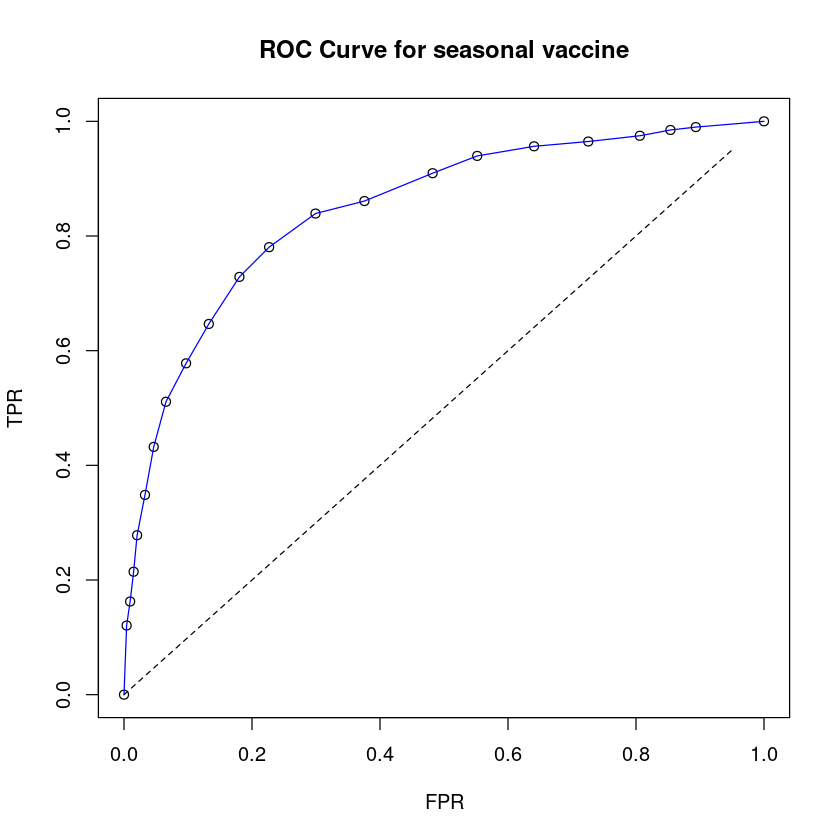

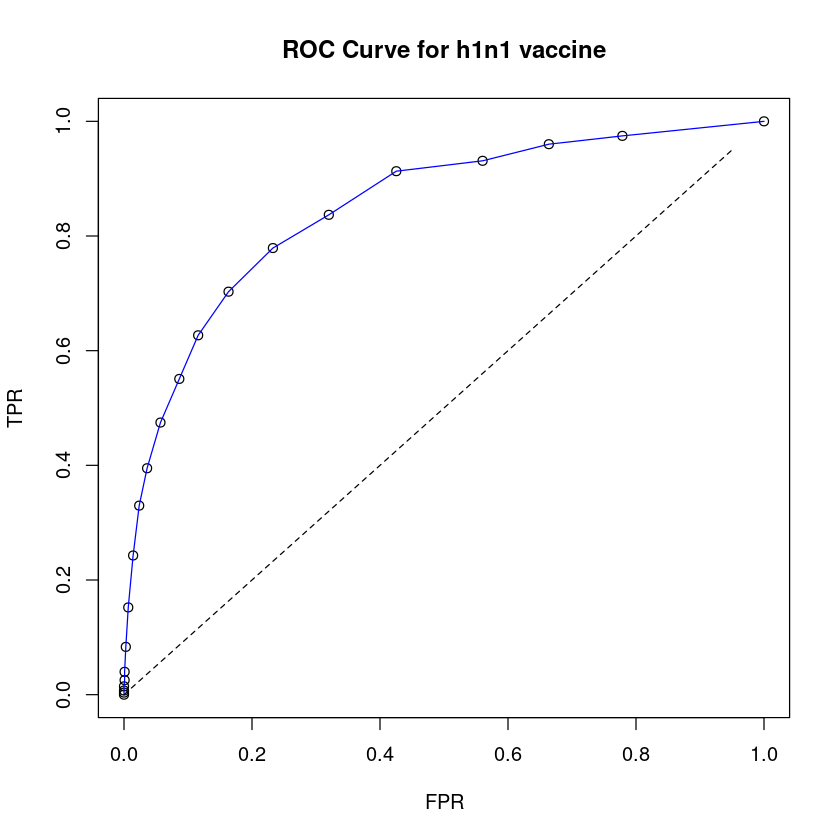

In [23]:
# ROC for seasonal vaccine

AUC_seasonal = AUCROC(Y_pred[,2], test_data[,targets[1]],"ROC Curve for seasonal vaccine")

# ROC for h1n1 vaccine

AUC_h1n1 =  AUCROC(Y_pred[,1], test_data[,targets[2]],"ROC Curve for h1n1 vaccine")

Now that the linear model is validated, it can be used to predict the outcome with the test set.

In [24]:
model <- lm(cbind(h1n1_vaccine, seasonal_vaccine)~., data=total_train_set)
summary(model)
Y_pred <- predict(model,pca_ts_set)

Response h1n1_vaccine :

Call:
lm(formula = h1n1_vaccine ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + 
    PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 + PC15 + 
    PC16 + PC17 + PC18 + PC19 + PC20 + PC21 + PC22 + PC23 + PC24 + 
    PC25 + PC26 + PC27 + PC28 + PC29 + PC30 + PC31 + PC32 + PC33 + 
    PC34 + PC35 + PC36 + PC37 + PC38 + PC39 + PC40 + PC41 + PC42 + 
    PC43 + PC44 + PC45 + PC46 + PC47 + PC48 + PC49 + PC50 + PC51 + 
    PC52 + PC53 + PC54, data = total_train_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95156 -0.21001 -0.07254  0.10617  1.19323 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.242945   0.067698   3.589 0.000333 ***
PC1          0.011476   0.007131   1.609 0.107551    
PC2          0.642089   0.012395  51.802  < 2e-16 ***
PC3          0.018383   0.013342   1.378 0.168265    
PC4         -0.298355   0.009788 -30.481  < 2e-16 ***
PC5          0.432738   0.012652  34.203  < 2e-16 ***
PC6          0.139736 

The summary of the model gives a better understanding of how it works with 26607 lines and 54 features. In reality, the outputs are split in two to present one and then the other. The p-value is a good indicator of the quality of the model and the features selected. Indeed, for the h1n1 vaccine, 32 features have a p-value indicating that they are statistically highly significant. For the seasonal vaccine, 37 features are in this case. The AUC of the seasonal vaccine is indeed higher. In all cases, the summary confirms that the chosen linear model is not the best one but works quite well for this problem.

## Model 2
Then we use the nnet package to make single layer neural network.

Let's define a function to compute neural networks effectiveness based on the number of hidden notes using cross-validation.

In [25]:
library(nnet)

In [26]:
auc_nnet_cross_valid <- function(X, Y, hidden_nodes=10,k=5){
    # Targe 0 for h1n1, 1 for seasonal
    accuracy_vec <- c()

    # 1. Shuffle the dataset randomly.
    shuffled_idx <- sample(1:nrow(X))
    half_split <- floor(nrow(X)/2)

    # 2. Split the dataset into k groups
    max <- ceiling(nrow(X)/k)
    splits <- split(shuffled_idx, ceiling(seq_along(shuffled_idx)/max))
    
    # 3. For each unique group:
    for (i in 1:k){
        #3.1 Take the group as a hold out or test data set
        X_test <- X[splits[[i]],]
        Y_test <- Y[splits[[i]]]
        
        #3.2 Take the remaining groups as a training data set
        X_train <- X[-splits[[i]],]
        Y_train <- Y[-splits[[i]]]
        # print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
        
        #3.3 Fit a model on the training set and evaluate it on the test set
        model <- nnet(x=X,
                     y=Y,
                     size=hidden_nodes,
                     skip=FALSE, maxit=1000,rang=1,MaxNWts=10000,trace=FALSE)
        print(paste("reached maxit ?",model$convergence))
        Y_pred<-predict(model,X_test)
        
        #3.4 Retain the evaluation score and discard the model
        accuracy_vec[i] <- compute_AUC(Y_pred, Y_test)
        break
    }
    
    return(mean(accuracy_vec))
}

[1] "[INFO] - Testing h= 10"
[1] "reached maxit ? 0"
[1] "reached maxit ? 1"
[1] "[INFO] - Testing h= 20"
[1] "reached maxit ? 0"
[1] "reached maxit ? 1"
[1] "[INFO] - Testing h= 30"
[1] "reached maxit ? 0"
[1] "reached maxit ? 0"
[1] "[INFO] - Testing h= 40"
[1] "reached maxit ? 1"
[1] "reached maxit ? 1"


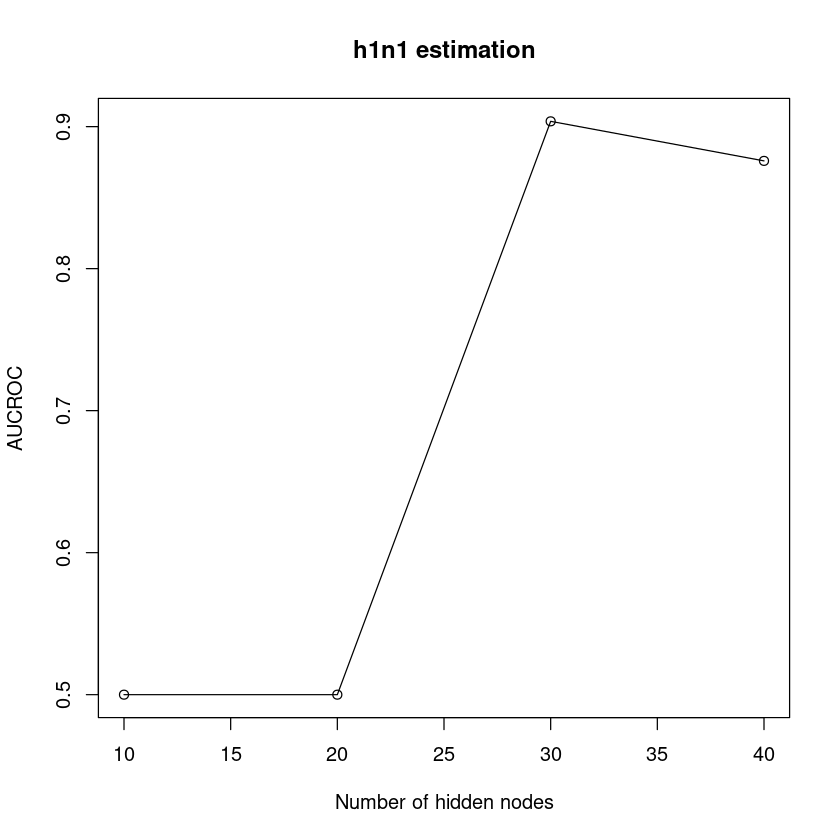

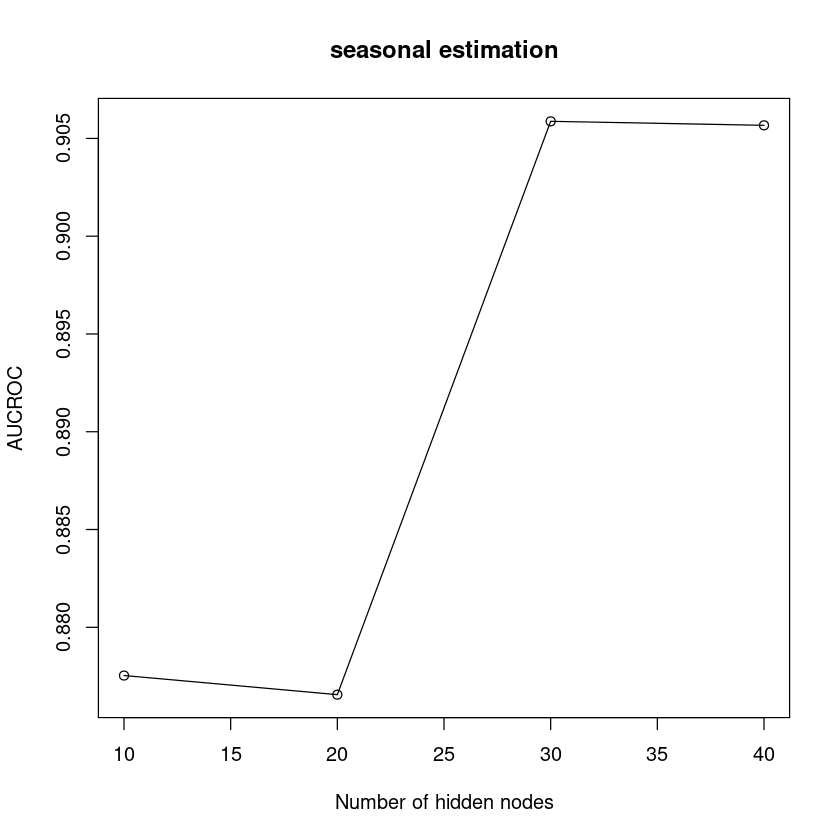

In [41]:
label_1 <- training_set_labels[,"h1n1_vaccine"]
label_2 <- training_set_labels[, "seasonal_vaccine"]
labels <- cbind(h1n1_vaccine=label_1, seasonal_vaccine=label_2)


k <- 2

hidden_nodes_vec <- seq(10, 40, 10)

results_h1n1 <- c()
results_season <- c()

for(hidden_nodes in hidden_nodes_vec){
    print(paste("[INFO] - Testing h=",hidden_nodes))
    results_h1n1 <- c(results_h1n1, auc_nnet_cross_valid(pca_tr_set, label_1, hidden_nodes=hidden_nodes,k=k))
    results_season <- c(results_season, auc_nnet_cross_valid(pca_tr_set, label_2, hidden_nodes=hidden_nodes,k=k))
}
# mean(AUC) according to the nb of hidden nodes 
plot(hidden_nodes_vec, results_h1n1, xlab="Number of hidden nodes", ylab="AUCROC", main="h1n1 estimation")
lines(hidden_nodes_vec, results_h1n1)

plot.new()

plot(hidden_nodes_vec, results_season, xlab="Number of hidden nodes", ylab="AUCROC", main="seasonal estimation")
lines(hidden_nodes_vec, results_season)

We see that the results are much better when predicting the seasonal vaccines.

In [ ]:
# Rename for the following
h1n1_nnet_pca <- results_h1n1
seasonal_nnet_pca <- results_season

# Model 3

The third model chosen is the SVM (Support Vector Machine), using the e1071 package. This method has usually good results even for data sets with many dimensions, which will be practical with the 54 features set selected by the PCA. The kernel and its parameters are also easily modular which allows us to test multiple combinations in order to find the one with the better results. The fact that the kernel can take other types then the linear one (polynomial, sigmoid or radial) also allows to evaluate efficiently data that are difficult to separate.

In [43]:
library("e1071")

#prediction for H1N1 column
model_svm1 = svm(label_1 ~ ., data = pca_tr_set, kernel = "radial", cost = 0.1, scale = FALSE)
Y_pred1 <- predict(model_svm1,pca_ts_set)
ss <- preProcess(as.data.frame(Y_pred1), method=c("range"))
Y_pred1 <- predict(ss, as.data.frame(Y_pred1))

#prediction for Seasonal Flu column
model_svm2 = svm(label_2 ~ ., data = pca_tr_set, kernel = "radial", cost = 0.1, scale = FALSE)
Y_pred2 <- predict(model_svm2,pca_ts_set)
ss <- preProcess(as.data.frame(Y_pred2), method=c("range"))
Y_pred2 <- predict(ss, as.data.frame(Y_pred2))

final_pred_SVM <- cbind(testing_features[, c(1)], Y_pred1, Y_pred2)
write.csv(final_pred_SVM, "test_submission_SVM.csv", row.names = F)

The function "svm()" can take a large amount of  different arguments,like the kernel type and its parameters. The arguments chosen in the code were selected after testing multiple combinations by computing their ROC and the AUC. Those results are shown in the following table. If some parameters are not specified hereunder, it means that the default values were used. Some values of the AUC for the "seasonal flue vaccines" are also missing because in view of the bad results of the "H1N1" column for this line, it was not deemed necessary to compute it.

| cost   | kernel       | gamma | coef0 | AUC H1N1 | AUC Flue |
|--------|--------------|-------|-------|----------|----------|
|0,00001 | linear       |       |       |   0,804  |   0,738  |
|0,00001 | polynomial 2 |       |       |   0,804  |   0,739  |
|0,00001 | polynomial 3 |       |       |   0,840  |   0,732  |
|0,00001 | polynomial 3 | 0,0001|   5   |   0,812  |   0,732  |
|0,000001| polynomial 3 |       |       |   0,813  |          |
|0,00001 | polynomial 4 |       |       |   0,811  |   0,725  |
|0,1     | polynomial 3 |       |       |   0,849  |   0,729  |
|0,01    | polynomial 3 |       |       |   0,844  |          |
|10      | polynomial 3 |       |       |   0,840  |   0,732  |
|1       | polynomial 3 |       |       |   0,849  |   0,739  |
|0,01    | radial       |       |       |   0,849  |   0,735  |
|0,1     | radial       |       |       |   0,849  |   0,741  |
|1       | radial       |       |       |   0,839  |   0,733  |
|10      | radial       |       |       |   0,842  |   0,733  |
|100     | radial       |       |       |   0,849  |   0,730  |
|0,01    | sigmoid      |       |       |   0,848  |   0,736  |
|0,1     | sigmoid      |       |       |   0,849  |   0,740  |
|1       | sigmoid      |       |       |   0,839  |   0,734  |
|10      | sigmoid      |       |       |   0,838  |   0,731  |

It can be deduced from the above table that this method generally gives better estimation for the H1N1 column than for the other.

# Alternative models


As an alternative model we chose to change our feature selection method. We tried to impplement multivariate neural networks but the computation times were so high we did not consider it interesting for our purposes.


## MRMR

The MRMR features selection method is chosen as an alternative to the PCA, to implement a method without using a library contained in the guidelines' list. This selection is the Minimum redundancy maximal relevancy filter (MRMR). It allows to have less features than the PCA but with a prediction that is normally just as good, maybe even better.

In [28]:
#install.packages(praznik)
library(praznik)

test_set <- ts_set_enc


X <- tr_set_enc
Y <- read.csv("training_set_labels.csv")
summary(Y)

results <- MRMR(X[, -c(1)], Y[, c(2)], 40, positive = T) # arbitrary number of cols to keep for h1n1
results$selection
results$score

results <- MRMR(X[, -c(1)], Y[, c(3)], 40, positive = T) # arbitrary number of cols to keep for seasonal
results$selection
results$score

features_to_keep = c(3,6,7,10,11,12,13,14,15,16,17,19,20,22,28,29,30,32,36,38,41,45,46,47,55,56,66,67,70,72,77,80,87,91,94)

mrmr_tr_set <- X[, features_to_keep]
mrmr_ts_set <- test_set[, features_to_keep]

 respondent_id    h1n1_vaccine    seasonal_vaccine
 Min.   :    0   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 6676   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :13353   Median :0.0000   Median :0.0000  
 Mean   :13353   Mean   :0.2125   Mean   :0.4656  
 3rd Qu.:20030   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :26706   Max.   :1.0000   Max.   :1.0000  

doctor_recc_h1n1    opinion_h1n1_vacc_effective 
                            10                             15 
            health_insurance_1                  health_worker 
                            28                             14 
             opinion_h1n1_risk   employment_industry_haxffmxo 
                            16                             35 
                    race_Black          chronic_med_condition 
                            76                             12 
          child_under_6_months                 h1n1_knowledge 
                            13                              2 
employment_occupation_xgwztkwe           doctor_recc_seasonal 
                            71                             11 
          behavioral_face_mask employment_occupation_rcertsgn 
                             5                             66 
             opinion_seas_risk employment_occupation_qxajmpny 
                            19                             65 
employment_occupation_uqqtjvyb employment_occupation_cmhcxjea 
                            69                             54 
  employment_industry_atmlpfrs employment_occupation_dcjcmpih 
                            31                             55 
           health_insurance_NA        hhs_geo_region_bhuqouqj 
                            29                             93 
         behavioral_touch_face   employment_industry_mcubkhph 
                             9                             37 
  employment_industry_rucpziij    opinion_seas_vacc_effective 
                            44                             18

doctor_recc_h1n1    opinion_h1n1_vacc_effective 
                  6.725550e-02                   2.862710e-02 
            health_insurance_1                  health_worker 
                  2.305181e-02                   9.749010e-03 
             opinion_h1n1_risk   employment_industry_haxffmxo 
                  1.605012e-02                   2.031052e-03 
                    race_Black          chronic_med_condition 
                  6.675594e-04                   6.688689e-04 
          child_under_6_months                 h1n1_knowledge 
                  5.335464e-04                   6.699246e-04 
employment_occupation_xgwztkwe           doctor_recc_seasonal 
                  5.085984e-04                   1.927928e-03 
          behavioral_face_mask employment_occupation_rcertsgn 
                  4.428736e-04                   3.145186e-04 
             opinion_seas_risk employment_occupation_qxajmpny 
                  1.196822e-03                   2.471329e-04 
employment_occupation_uqqtjvyb employment_occupation_cmhcxjea 
                  2.150596e-04                   5.289864e-04 
  employment_industry_atmlpfrs employment_occupation_dcjcmpih 
                  1.524687e-04                   2.185837e-04 
           health_insurance_NA        hhs_geo_region_bhuqouqj 
                  7.026136e-04                   2.182112e-04 
         behavioral_touch_face   employment_industry_mcubkhph 
                  1.317936e-04                   1.025550e-04 
  employment_industry_rucpziij    opinion_seas_vacc_effective 
                  5.943325e-05                   1.014761e-04

opinion_seas_vacc_effective           doctor_recc_seasonal 
                            18                             11 
                     age_group              opinion_seas_risk 
                            21                             19 
            health_insurance_1                  health_worker 
                            28                             14 
         chronic_med_condition          behavioral_touch_face 
                            12                              9 
                    race_White employment_occupation_qxajmpny 
                            79                             65 
  employment_status_Unemployed   employment_industry_rucpziij 
                            90                             44 
            health_insurance_0               doctor_recc_h1n1 
                            27                             10 
  employment_industry_haxffmxo                 h1n1_knowledge 
                            35                              2 
employment_occupation_uqqtjvyb    opinion_h1n1_vacc_effective 
                            69                             15 
employment_occupation_xgwztkwe               rent_or_own_Rent 
                            71                             86 
  employment_industry_vjjrobsf          behavioral_wash_hands 
                            46                              6 
  employment_industry_saaquncn              opinion_h1n1_risk 
                            45                             16 
  employment_industry_mcubkhph   employment_industry_nduyfdeo 
                            37                             40 
  employment_industry_xicduogh employment_occupation_xqwwgdyp 
                            49                             72 
       hhs_geo_region_lrircsnp employment_occupation_dcjcmpih 
                            97                             55 
            household_children employment_occupation_cmhcxjea 
                            26                             54 
                  h1n1_concern 
                             1

opinion_seas_vacc_effective           doctor_recc_seasonal 
                  8.250000e-02                   4.539620e-02 
                     age_group              opinion_seas_risk 
                  2.426957e-02                   2.764367e-02 
            health_insurance_1                  health_worker 
                  5.128553e-03                   5.023535e-03 
         chronic_med_condition          behavioral_touch_face 
                  3.026414e-03                   3.238610e-03 
                    race_White employment_occupation_qxajmpny 
                  2.175402e-03                   2.052228e-03 
  employment_status_Unemployed   employment_industry_rucpziij 
                  1.585190e-03                   1.374028e-03 
            health_insurance_0               doctor_recc_h1n1 
                  1.282449e-03                   2.301593e-03 
  employment_industry_haxffmxo                 h1n1_knowledge 
                  1.272818e-03                   1.647977e-03 
employment_occupation_uqqtjvyb    opinion_h1n1_vacc_effective 
                  1.183991e-03                   2.284414e-03 
employment_occupation_xgwztkwe               rent_or_own_Rent 
                  8.093634e-04                   9.898862e-04 
  employment_industry_vjjrobsf          behavioral_wash_hands 
                  7.111167e-04                   7.597001e-04 
  employment_industry_saaquncn              opinion_h1n1_risk 
                  5.368513e-04                   6.637580e-04 
  employment_industry_mcubkhph   employment_industry_nduyfdeo 
                  4.167304e-04                   3.513105e-04 
  employment_industry_xicduogh employment_occupation_xqwwgdyp 
                  3.301422e-04                   3.097286e-04 
       hhs_geo_region_lrircsnp employment_occupation_dcjcmpih 
                  3.113976e-04                   2.104316e-04 
            household_children employment_occupation_cmhcxjea 
                  3.316231e-04                   1.441179e-04 
                  h1n1_concern 
                  1.544027e-05

The selection of features is made for one output and then the other. It remained to choose which features to keep from all those that emerged. 19 features were common to both labels so they were kept. For the h1n1_vaccine label, 8 additional features were selected but only 7 had a sufficient score to be considered interesting. For seasonal_vaccine, 13 additional features and 9 are interesting. In total there will be 35 features for both outputs. This is less than with the PCA.

### Linear model with MRMR

The steps are the same than with PCA, only the results will eventually change.

In [29]:
total_train_set <- cbind(mrmr_tr_set, labels)

In [30]:
# Separation of the train in two groups in order to calculate the error between prediction and reality.
vaccine_idx <- sample(1:nrow(total_train_set))
half_split <- floor(nrow(total_train_set)/2)
train_data_set <- total_train_set[vaccine_idx[1:half_split],]
test_data <- total_train_set[vaccine_idx[(half_split+1):nrow(total_train_set)],]
target_idx <- ncol(train_data_set)
targets <- c(target_idx, target_idx-1)

# Linear model & prediction
model <- lm(cbind(h1n1_vaccine, seasonal_vaccine)~., data=train_data_set)
Y_pred <- predict(model,test_data[,-targets])

In [31]:
k = 10
accuracy_vec_h1n1 <- array(0,k)
accuracy_vec_seasonal <- array(0,k)
threshold <- 0.5

# 1. Shuffle the dataset randomly.
vaccine_idx <- sample(1:nrow(train_data_set))

# 2. Split the dataset into k groups
max <- ceiling(nrow(train_data_set)/k)
splits <- split(vaccine_idx, ceiling(seq_along(vaccine_idx)/max))

# 3. For each unique group:
for (i in 1:k){
  #3.1 Take the group as a hold out or test data set
  test_data <- train_data_set[splits[[i]],]
  
  #3.2 Take the remaining groups as a training data set
  train_data <- train_data_set[-splits[[i]],]
  print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
  
  #3.3 Fit a model on the training set and evaluate it on the test set
  model <- lm(cbind(h1n1_vaccine, seasonal_vaccine) ~ ., data=train_data)
  Y_pred <- predict(model,test_data[,-targets])
  Y_h1n1 <- test_data[,targets[2]]
  Y_seasonal <- test_data[,targets[1]]
  
  #3.4 Store the prediction of the tree (2 is to take only the P(Y="spam"|x))
  Y_hat <- ifelse(Y_pred > threshold,1,0) 
  # Need one confusion matrix for h1n1 and one for seasonal
  confusion_matrix_h1n1 <- table(Y_hat[,1],Y_h1n1)
  confusion_matrix_seasonal <- table(Y_hat[,2],Y_seasonal)
  
  #3.5 Retain the evaluation score and discard the model
  accuracy_vec_h1n1[i] = (confusion_matrix_h1n1[1,1]+confusion_matrix_h1n1[2,2])/sum(confusion_matrix_h1n1)
  misclassification_rate = 1 - accuracy_vec_h1n1[i]
  print(paste("[INFO] - Misclassification rate h1n1 -",i,"fold:",misclassification_rate))
  
  accuracy_vec_seasonal[i] = (confusion_matrix_seasonal[1,1]+confusion_matrix_seasonal[2,2])/sum(confusion_matrix_seasonal)
  misclassification_rate = 1 - accuracy_vec_seasonal[i]
  print(paste("[INFO] - Misclassification rate seasonal -",i,"fold:",misclassification_rate))
  
}

#4. Summarize the skill of the model using the sample of model evaluation scores
print(paste("[INFO] - Mean misclassification rate h1n1:",1-mean(accuracy_vec_h1n1)))
print(paste("[INFO] - Mean misclassification rate seasonal:",1-mean(accuracy_vec_seasonal)))

[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 1 fold: 0.147455089820359"
[1] "[INFO] - Misclassification rate seasonal - 1 fold: 0.229041916167665"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 2 fold: 0.150449101796407"
[1] "[INFO] - Misclassification rate seasonal - 2 fold: 0.230538922155689"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 3 fold: 0.141467065868264"
[1] "[INFO] - Misclassification rate seasonal - 3 fold: 0.229041916167665"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 4 fold: 0.148952095808383"
[1] "[INFO] - Misclassification rate seasonal - 4 fold: 0.226047904191617"
[1] "[INFO] - Training set size: 12017 - Testing set size 1336"
[1] "[INFO] - Misclassification rate h1n1 - 5 fold: 0.154940119760479"
[1] "[INFO] - Misclassifi

Warning message in if (rownames(confusion_matrix) == 1) {:
“the condition has length > 1 and only the first element will be used”


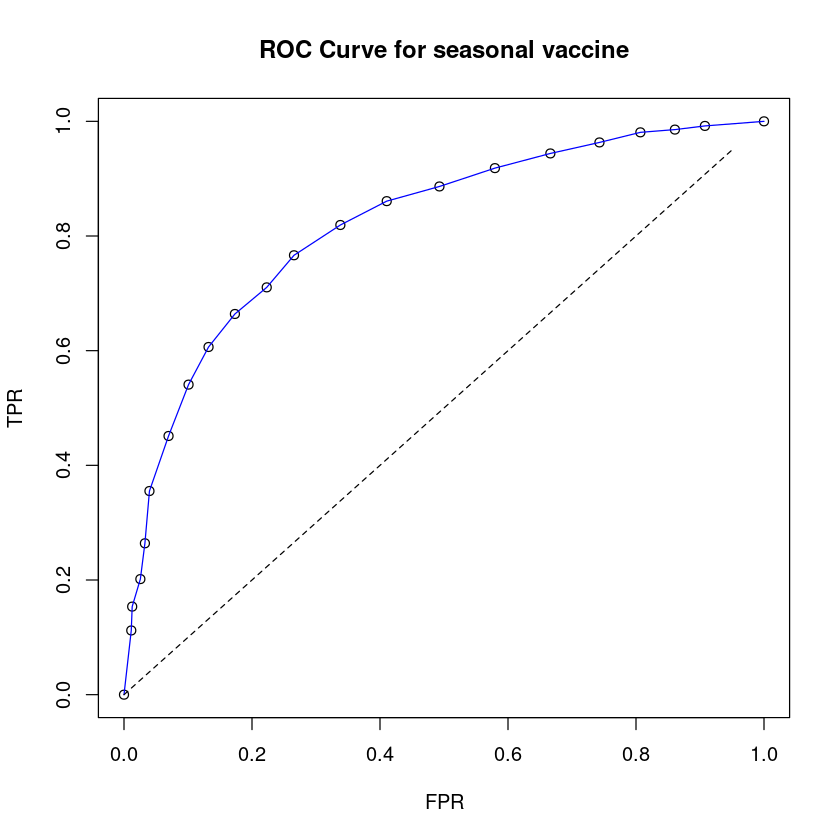

[1] "AUC for h1n1 : 0.834994556864754 AUC for seasonal : 0.819988636363636"


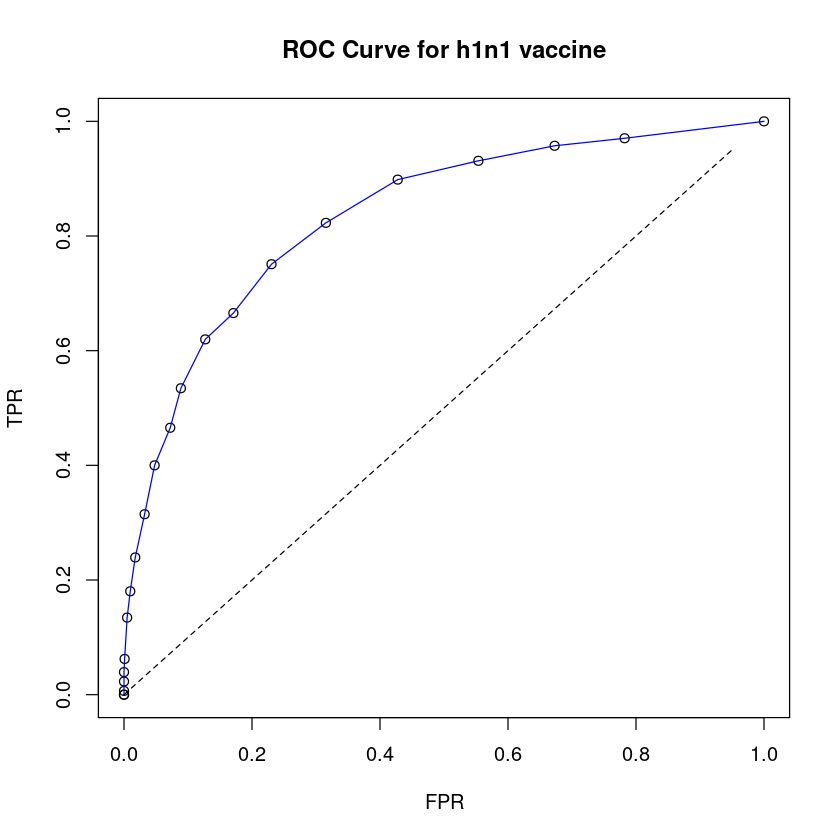

In [32]:
# ROC for seasonal vaccine

AUC_seasonal = AUCROC(Y_pred[,2], test_data[,targets[1]],"ROC Curve for seasonal vaccine")

# ROC for h1n1 vaccine

AUC_h1n1 =  AUCROC(Y_pred[,1], test_data[,targets[2]],"ROC Curve for h1n1 vaccine")

print(paste("AUC for h1n1 :", AUC_h1n1, "AUC for seasonal :", AUC_seasonal)) 

The AUC is better for seasonal_vaccine but worse for h1n1_vaccine. The linear model is therefore better suited with PCA to predict h1n1_vaccine.

In [33]:
model <- lm(cbind(h1n1_vaccine, seasonal_vaccine)~., data=total_train_set)
summary(model)
Y_pred <- predict(model,mrmr_ts_set)

Response h1n1_vaccine :

Call:
lm(formula = h1n1_vaccine ~ h1n1_knowledge + behavioral_face_mask + 
    behavioral_wash_hands + behavioral_touch_face + doctor_recc_h1n1 + 
    doctor_recc_seasonal + chronic_med_condition + child_under_6_months + 
    health_worker + opinion_h1n1_vacc_effective + opinion_h1n1_risk + 
    opinion_seas_vacc_effective + opinion_seas_risk + age_group + 
    health_insurance_0 + health_insurance_1 + health_insurance_NA + 
    employment_industry_atmlpfrs + employment_industry_haxffmxo + 
    employment_industry_mcubkhph + employment_industry_nduyfdeo + 
    employment_industry_rucpziij + employment_industry_saaquncn + 
    employment_industry_vjjrobsf + employment_occupation_cmhcxjea + 
    employment_occupation_dcjcmpih + employment_occupation_qxajmpny + 
    employment_occupation_rcertsgn + employment_occupation_uqqtjvyb + 
    employment_occupation_xgwztkwe + race_Black + race_White + 
    rent_or_own_Rent + employment_status_Unemployed + hhs_geo_region_b

### Single layer neural network with mrmr

Once again the steps are very similar to what was done previously for the neural networks. We observe better results for the estimation of seasonal flue vaccines than for h1n1. 

[1] "[INFO] - Testing h= 5"
[1] "reached maxit ? 0"
[1] "reached maxit ? 1"
[1] "[INFO] - Testing h= 10"
[1] "reached maxit ? 0"
[1] "reached maxit ? 0"
[1] "[INFO] - Testing h= 15"
[1] "reached maxit ? 0"
[1] "reached maxit ? 0"


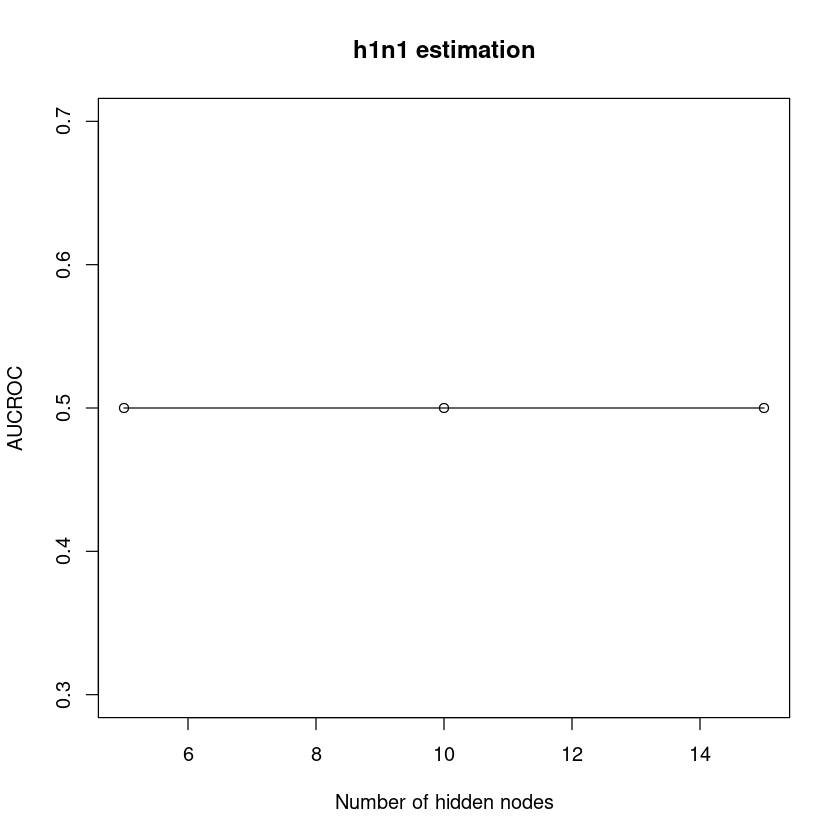

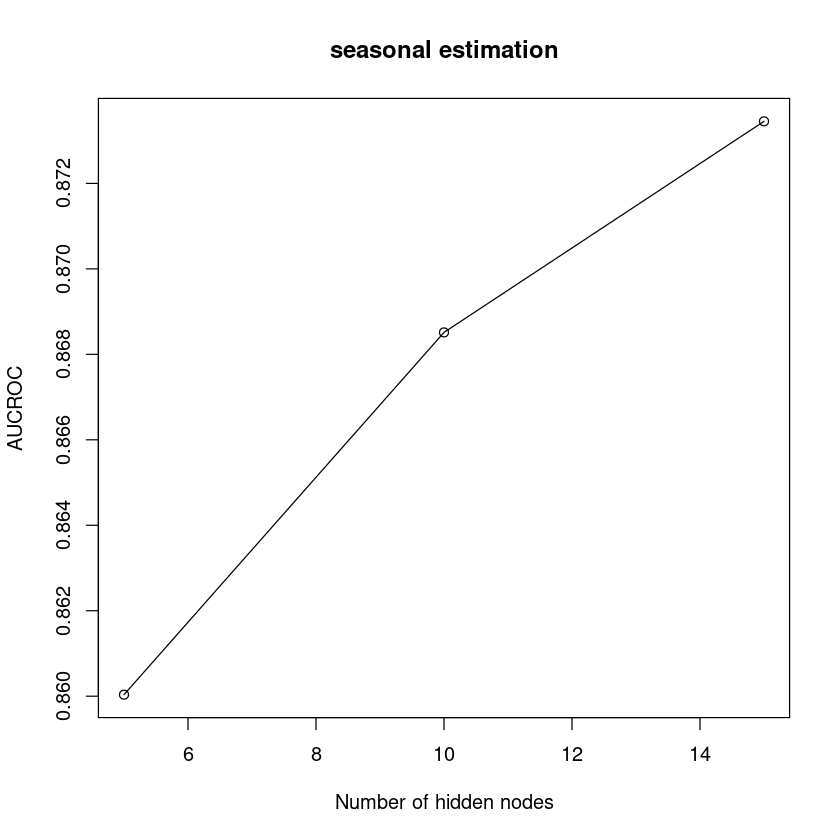

In [39]:
k <- 2

hidden_nodes_vec <- c(5, 10, 15)
results1 <- c()
results2 <- c()
for(hidden_nodes in hidden_nodes_vec){
    print(paste("[INFO] - Testing h=",hidden_nodes))
    results1 <- c(results1, auc_nnet_cross_valid(mrmr_tr_set, label_1, hidden_nodes=hidden_nodes,k=k))
    results2 <- c(results2, auc_nnet_cross_valid(mrmr_tr_set, label_2, hidden_nodes=hidden_nodes,k=k))
}
#mean(AUC) according to the nb of hidden nodes 
plot(hidden_nodes_vec, results1, xlab="Number of hidden nodes", ylab="AUCROC", main="h1n1 estimation")
lines(hidden_nodes_vec, results1)

plot.new()

plot(hidden_nodes_vec, results2, xlab="Number of hidden nodes", ylab="AUCROC", main="seasonal estimation")
lines(hidden_nodes_vec, results2)


### SVM with mrmrm

The code is the same as above. The results for the estimation of seasonal flue vaccines are better than when the features selection was done by PCA, but the AUC for the H1N1 column are a slightly less good.

In [ ]:
library("e1071")

model_svm1 = svm(label_1 ~ ., data = mrmr_tr_set, kernel = "polynomial", degree=3, cost = 1, scale = FALSE)
Y_pred1 <- predict(model_svm1,mrmr_ts_set)
ss <- preProcess(as.data.frame(Y_pred1), method=c("range"))
Y_pred1 <- predict(ss, as.data.frame(Y_pred1))

model_svm2 = svm(label_2 ~ ., data = mrmr_tr_set, kernel = "polynomial", degree=3, cost = 0.01, scale = FALSE)
Y_pred2 <- predict(model_svm2,mrmr_ts_set)
ss <- preProcess(as.data.frame(Y_pred2), method=c("range"))
Y_pred2 <- predict(ss, as.data.frame(Y_pred2))

final_pred_SVM <- cbind(testing_features[, c(1)], Y_pred1, Y_pred2)

Compared to the SVM code applied after the PCA, the kernel parameters and the cost have changed because the previous values werent optimal anymore.

### Combination of the three methods
To optimise the results, we'll be taking all three methods' results and we'll taking their mean.

In [ ]:
# H1N1 column
pred_linear_H1N1<-Y_pred[,2]
pred_svm_H1N1<-results_1
pred_svm_H1N1<- final_pred_SVM[,2]

#Seasonal flue column
pred_linear_seasonable<-Y_pred[,3]
pred_svm_seasonable<-results_seasonal
pred_svm_seasonable<- final_pred_SVM[,3]



# Conclusions

The linear model was very easy and fast to use. The results of this method are pretty good despite of how simple it is. In the end, it was the most efficient method that we used and submitted on Driven Data.

Then, the neural netmork was an intereseting model but it was too heavy to run and prevents us to proceed to further tests. The final ressults were good for the "Seasonal Flue" column but it's wasn't satisfying for the "H1N1" column.

The SVM was an in-between in term of running time. But the large possibility of combinations of the kernel's parameters prevented from making an efficient exhaustive testing. The final parameter choice suggested the possibility to have a good model with this technique. The "AUC" computed for the final model instance present in the notebook is significantly better "H1N1 vaccines" than for "Seasonal Flue Vaccines".

Concerning MRMR, it has eliminated more features than PCA and therefore may be more suitable for models that do not support many features. In the future, if another model is proposed, the selection of features can be chosen to give the best results. In the case of this project for example, svm is able to handle a lot of features so MRMR barely improves or worsens the prediction whereas neural networks was more efficient with less features and returned better results.

Finally, a combination of the neural network to predict the "Seasonal Flue" column and of the SVM to estimate the "H1N1" column was submited on Driven Data. The team thought it would get the best score among all the subitted files, but this score ended up being lower than the linear model's one which was surpising. The difference between this result and the one we computed ourself with the AUC could be due to overfitting.

A second submission was made by computing the mean between the previous submission and the linear model prediction. We didn't had the results for this last solution because we didn't have any submission left.To conclude, it's a good thing to adapt our features selection technique to the need of the used machine learning method and more computational power could have allowed to study more complex models (like multi-variate random forest or more complex kernel types for the SVM). It would also allow us to execute more extensive testing.

